In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import shap
import statsmodels.api as sm
from scipy import stats

import os
import src

from dotenv import load_dotenv

from numpy.testing import assert_almost_equal

Необходимые опции

In [3]:
pd.options.display.float_format = '{:,.2f}'.format

Загрузка данных и подготовка

In [4]:
# load_dotenv(override=True)
#
# WORK_DIR = os.getenv("RAW_DIR")
# FILE_NAME = os.getenv("RAW_DF_NAME")
#
# filepath = f'..\\..\\{WORK_DIR}\\{FILE_NAME}'
#
# df1 = pd.read_csv(filepath + '101.zip', index_col=0, parse_dates=True)
# df2 = pd.read_csv(filepath + '102.zip', index_col=0, parse_dates=True)
# df3 = pd.read_csv(filepath + '103.zip', index_col=0, parse_dates=True)
# df4 = pd.read_csv(filepath + '104.zip', index_col=0, parse_dates=True)

In [4]:
load_dotenv(override=True)

WORK_DIR = os.getenv("RAW_DIR")
filepath = f'..\\..\\{WORK_DIR}\\df_raw_test.zip'

df = pd.read_csv(filepath, index_col=0, parse_dates=True)

In [5]:
df.shape

(96738, 53)

In [5]:
# cols = [
#     'Fel_1',
#     'Fel_2',
#     'D_SL',
#     'QQ_C1',
#     'QQ_C2',
#     'QQ_C3',
#     'QQ_C4',
#     'QQ_C5',
#     'O2_tot',
#     'QQ_tot',
#     'Sl_tot',
#     'O2_C1',
#     'O2_C2',
#     'O2_C3',
#     'O2_C4',
#     'O2_C5',
#     'AC_level',
#     'AC_rbk_open',
#     'AC_valve_open',
#     'P_H2O',
#     'P_O2',
#     'P_tot',
#     'P_valve',
#     'P_tot_2',
#     'T_C1',
#     'T_C2',
#     'T_C3',
#     'T_C4',
#     'T_C5',
#     'T_abg',
#     'P_O2_in',
#     'FT1_level',
#     'FT1_P',
#     'FT1_T_in',
#     'FT1_T',
#     'FT2_level',
#     'FT2_P',
#     'FT2_T',
#     'Cond_Q',
#     'Cond_level',
#     'Cond_valve',
#     'O2_conc_1',
#     'O2_conc_2',
#     'Fe',
#     'Stot',
#     'SO4',
#     'As',
#     'Corg',
#     'Ctot',
#     'Fe2+',
#     'D_S',
#     'D_SL_H'
# ]
#
# df1.columns = cols
# df2.columns = cols
# df3.columns = cols
# df4.columns = cols

In [6]:
print(f"В модели используются данные с начала {df.index.min().year} года по конец {df.index.max().year} года.")

В модели используются данные с начала 2019 года по конец 2021 года.


In [7]:
df.columns

Index(['Fel_1', 'Fel_2', 'D_SL', 'QQ_C1', 'QQ_C2', 'QQ_C3', 'QQ_C4', 'QQ_C5',
       'O2_tot', 'QQ_tot', 'Sl_tot', 'O2_C1', 'O2_C2', 'O2_C3', 'O2_C4',
       'O2_C5', 'AC_level', 'AC_rbk_open', 'AC_valve_open', 'P_H2O', 'P_O2',
       'P_tot', 'P_valve', 'P_tot_2', 'T_C1', 'T_C2', 'T_C3', 'T_C4', 'T_C5',
       'T_abg', 'P_O2_in', 'FT1_level', 'FT1_P', 'FT1_T_in', 'FT1_T',
       'FT2_level', 'FT2_P', 'FT2_T', 'Cond_Q', 'Cond_level', 'Cond_valve',
       'O2_conc_1', 'O2_conc_2', 'Fe', 'Stot', 'SO4', 'As', 'Corg', 'Ctot',
       'Fe2+', 'D_S', 'D_SL_H', 'ac'],
      dtype='object')

# Анализ данных

Оставим только те данные, когда автоклав работал

In [8]:
fel_sum = df['Fel_1'] + df['Fel_2']
df = df.assign(Fel_sum=fel_sum.values)

df['work'] = np.where((df['Fel_sum'] >= 30), 1, 0)
df.reset_index(inplace=True)
df.drop(df[df['work'] == 0].index, inplace=True)
df.drop('work', axis=1, inplace=True)

df = df.set_index('index')
df.index.name = ""

print(df.shape)

(51053, 54)


Проверим массив данных на пустые значения

In [9]:
null_check = df.isna().sum()
null_check[null_check > 0]

Fe        48509
Stot      48227
SO4       50391
As        48503
Corg      48245
Ctot      48233
Fe2+          8
D_S       47190
D_SL_H    47428
dtype: int64

## Целевая метрика - концентрация железа 2+

In [10]:
df_fe = df[['Fe2+', 'ac']].copy()
df_fe = df_fe.assign(year = df_fe.index.year)

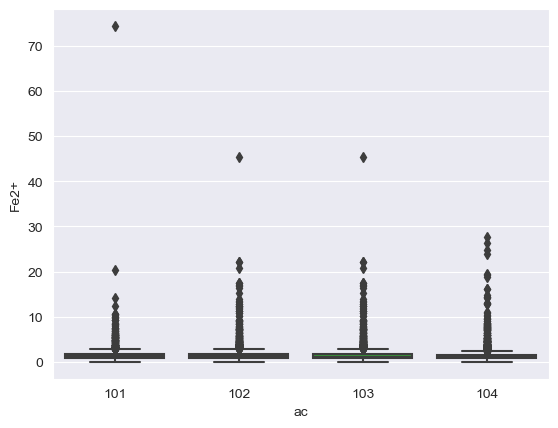

In [11]:
sns.boxplot(data=df_fe, y='Fe2+', x='ac');

In [12]:
df_fe.groupby(by=['ac', 'year']).mean()

Fe2+
ac  year      
101 2019  0.75
    2020  1.06
    2021  1.72
102 2019  0.87
    2020  1.07
    2021  1.79
103 2019  0.87
    2020  1.07
    2021  1.82
104 2019  0.89
    2020  1.17
    2021  1.66

In [21]:
df_fe.head(10)

,Fe2+,ac,year
,,,
2019-01-01 07:00:00,0.00,101,2019
2019-01-01 08:00:00,1.11,101,2019
2019-01-01 09:00:00,0.00,101,2019
2019-01-01 10:00:00,1.23,101,2019
2019-01-01 11:00:00,0.00,101,2019
2019-01-01 12:00:00,1.34,101,2019
2019-01-01 13:00:00,0.00,101,2019
2019-01-01 14:00:00,1.11,101,2019
2019-01-01 15:00:00,0.00,101,2019


In [24]:
df_fe.loc[(df_fe['ac'] == 101) & (df_fe['year'] == 2019)]['Fe2+'].describe()

count   1,596.00
mean        0.75
std         0.65
min         0.00
25%         0.00
50%         0.75
75%         1.12
max         8.47
Name: Fe2+, dtype: float64

In [25]:
df_fe[(df_fe['ac'] == 103) & (df_fe['year'] == 2019)]['Fe2+'].count()

2384

In [26]:
df_fe[(df_fe['ac'] == 103) & (df_fe['year'] == 2019) & (df_fe['Fe2+'] == 0)]['Fe2+'].count()

360

Что мы видим:
1. Есть значения, которые сильно большие и вызывают сомнения. Скорее всего это ошибки анализа на железо или это точки представляют совсем плохой режим, может во время запуска. **Решение - убрать все точки по концентрации железа больше 20 г/л.** Этот параметр может быть потом изменен.
2. Могут быть значения концентрации равные 0, это скорее всего отсутствие реальных данных, чем результат измерения. **Решение - убрать все значения концентрации равные 0.** Таких значений в реальной жизни быть не может, следовательно, это ошибки или отсутствие анализов.

Эти правила нужно будет добавить в функцию очистки данных!!!



In [29]:
before_zeros_del = df_fe.shape[0]

In [30]:
FE_MAX = 20
FE_MIN = 0

df_fe.drop(df_fe[df_fe['Fe2+'] == FE_MIN].index, inplace=True)
df_fe.drop(df_fe[df_fe['Fe2+'] > FE_MAX].index, inplace=True)

In [31]:
after_zeroes_del = df_fe.shape[0]
print(f'Всего с нулевыми значениями было удалено {before_zeros_del - after_zeroes_del} объектов, что составляло {(before_zeros_del - after_zeroes_del) / before_zeros_del * 100:.1f} %.')
print(f'Осталось {after_zeroes_del} объектов.')

Всего с нулевыми значениями было удалено 3242 объектов, что составляло 6.4 %.
Осталось 47811 объектов.


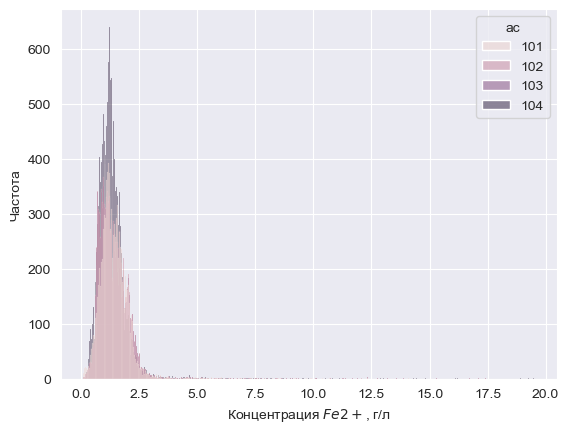

In [33]:
ax = sns.histplot(data=df_fe.reset_index(), x='Fe2+', hue='ac');

ax.set_xlabel("Концентрация $Fe2+$, г/л")
ax.set_ylabel("Частота")

plt.show();

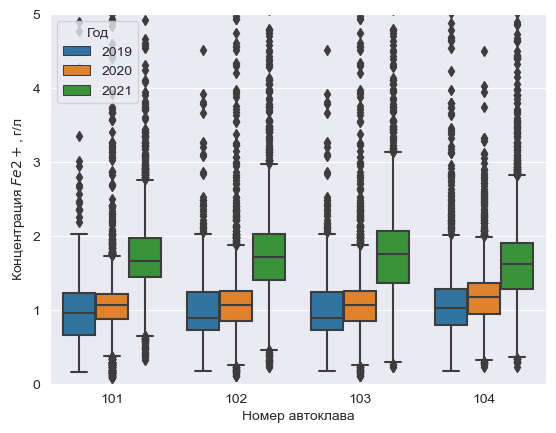

In [34]:
ax = sns.boxplot(data=df_fe, y='Fe2+', x='ac', hue='year', whis=1.5)

ax.set_ylabel("Концентрация $Fe2+$, г/л")
ax.set_xlabel("Номер автоклава")

plt.legend(title="Год")

ax.set_ylim([0, 5])

plt.show();

Попробуем посчитать сколько точек выходит за 3 сигмы.

In [36]:
x = df_fe.loc[(df_fe['year'] == 2021) & (df_fe['ac'] == 101)]['Fe2+']
print(f'Разброс ≈95% интервал {x.mean():.2f} ± {x.std() * 2:.2f}')

Разброс ≈95% интервал 1.73 ± 1.27


In [23]:
print(f'Медиана: {x.median()}')
print(f'Q1: {x.quantile(0.25)}, Q3: {x.quantile(0.75)}')
IRQ = x.quantile(0.75) - x.quantile(0.25)
print(f'IRQ: {IRQ:.2f}')
min_level = x.quantile(0.25) - 1.5 * IRQ
max_level = x.quantile(0.75) + 1.5 * IRQ
print(f'Min level: {min_level:.2f}')
print(f'Max level: {max_level:.2f}')


Медиана: 1.66
Q1: 1.44, Q3: 1.97
IRQ: 0.53
Min level: 0.64
Max level: 2.77


In [38]:
def stat_min_max(array, scale=1.5) -> tuple:
    irq = array.quantile(0.75) - array.quantile(0.25)
    min_level = array.quantile(0.25) - scale * irq
    max_level = array.quantile(0.75) + scale * irq

    return min_level, max_level


In [39]:
for ac in [101, 102, 103, 104]:
    print(f'Автоклав {ac}')

    for year in [2019, 2020, 2021]:

        print(f'Год {year}')
        ar = df_fe.loc[(df_fe['year'] == year) & (df_fe['ac'] == ac)]
        min_l, max_l = stat_min_max(ar['Fe2+'])

        print(f'Min level {min_l:.2f}, max level {max_l:.2f}')

        out_value_count = ar.query("@min_l < `Fe2+` > @max_l")['Fe2+'].count()

        in_value_count = ar.shape[0]

        print(
            f"Общее число точек: {in_value_count}, из них выпадает более чем на 3 IRQ: {out_value_count}, что составляет {out_value_count / in_value_count * 100:.2f}%")

    print('*' * 10)

Автоклав 101
Год 2019
Min level -0.19, max level 2.08
Общее число точек: 1191, из них выпадает более чем на 3 IRQ: 21, что составляет 1.76%
Год 2020
Min level 0.37, max level 1.73
Общее число точек: 4123, из них выпадает более чем на 3 IRQ: 133, что составляет 3.23%
Год 2021
Min level 0.64, max level 2.77
Общее число точек: 5392, из них выпадает более чем на 3 IRQ: 139, что составляет 2.58%
**********
Автоклав 102
Год 2019
Min level -0.06, max level 2.02
Общее число точек: 2018, из них выпадает более чем на 3 IRQ: 39, что составляет 1.93%
Год 2020
Min level 0.23, max level 1.88
Общее число точек: 4163, из них выпадает более чем на 3 IRQ: 133, что составляет 3.19%
Год 2021
Min level 0.46, max level 2.97
Общее число точек: 5471, из них выпадает более чем на 3 IRQ: 140, что составляет 2.56%
**********
Автоклав 103
Год 2019
Min level -0.06, max level 2.02
Общее число точек: 2018, из них выпадает более чем на 3 IRQ: 39, что составляет 1.93%
Год 2020
Min level 0.23, max level 1.88
Общее числ

Сильно выпадающих значений не очень много, можно на первое время их оставить. Если модель будет сильно ошибаться в пиках, то можно немного сгладить данные.

### Соответствие распределения концентрации железа нормальному

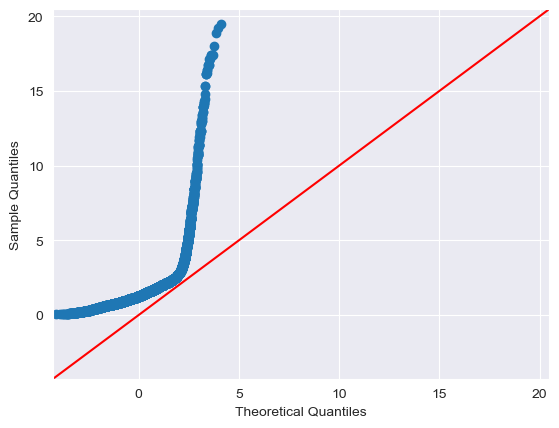

In [28]:
sm.qqplot(df_fe['Fe2+'], line='45');

Распределение вообще не похоже на нормальное, имеет место большой хвост. Есть техники приведения распределения к номральному виду. Попробуем применить Box-Cox метод.

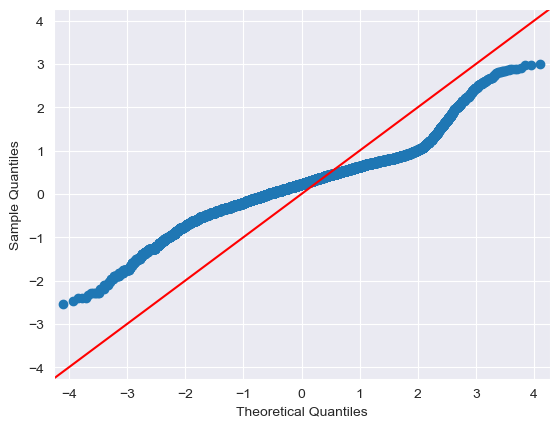

In [29]:
df_fe_norm, _ = stats.boxcox(df_fe['Fe2+'])
sm.qqplot(df_fe_norm, line='45');

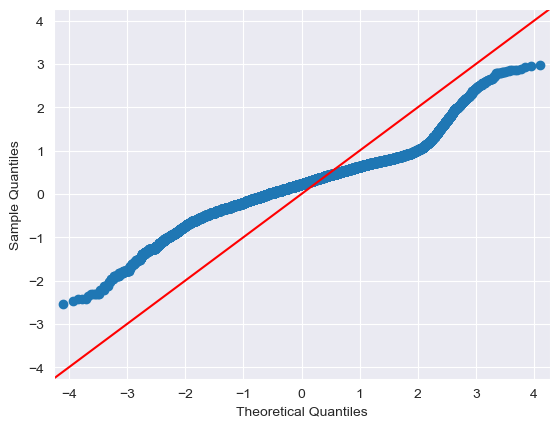

In [30]:
df_fe_ln = np.log(df_fe['Fe2+'])
sm.qqplot(df_fe_ln, line='45');

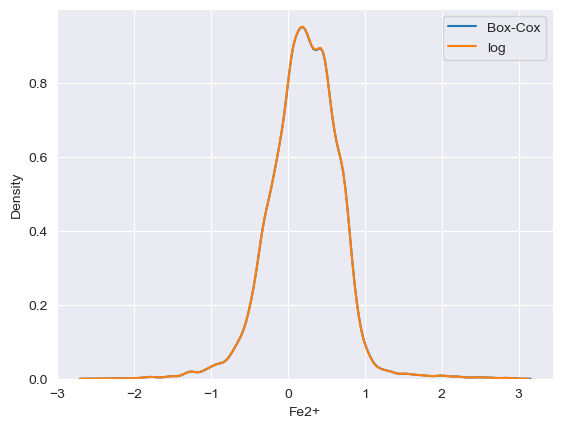

In [31]:
ax = sns.kdeplot(df_fe_norm, label='Box-Cox')
sns.kdeplot(df_fe_ln.reset_index()['Fe2+'], label='log')
ax.legend()
plt.show()

Теперь распределение целевой переменной уже ближе к нормальному. В целом это надо запомнить и применить для тюнинга модели.

## Анализ состава исходного сырья

Посмотрим, как исходное сырье распределено во времени. Может быть можно выделить различные типы сырья и добавить категориальные признаки.

In [40]:
df.columns

Index(['Fel_1', 'Fel_2', 'D_SL', 'QQ_C1', 'QQ_C2', 'QQ_C3', 'QQ_C4', 'QQ_C5',
       'O2_tot', 'QQ_tot', 'Sl_tot', 'O2_C1', 'O2_C2', 'O2_C3', 'O2_C4',
       'O2_C5', 'AC_level', 'AC_rbk_open', 'AC_valve_open', 'P_H2O', 'P_O2',
       'P_tot', 'P_valve', 'P_tot_2', 'T_C1', 'T_C2', 'T_C3', 'T_C4', 'T_C5',
       'T_abg', 'P_O2_in', 'FT1_level', 'FT1_P', 'FT1_T_in', 'FT1_T',
       'FT2_level', 'FT2_P', 'FT2_T', 'Cond_Q', 'Cond_level', 'Cond_valve',
       'O2_conc_1', 'O2_conc_2', 'Fe', 'Stot', 'SO4', 'As', 'Corg', 'Ctot',
       'Fe2+', 'D_S', 'D_SL_H', 'ac', 'Fel_sum'],
      dtype='object')

In [41]:
df_chem = df.loc[:, ['Fel_1', 'Fel_2', 'Fe', 'Stot', 'SO4', 'As', 'Corg', 'Ctot', 'Fe2+', 'D_S', 'D_SL_H', 'ac']]

In [42]:
int_cols = [
    'Fe',
    'Stot',
    'SO4',
    'As',
    'Corg',
    'Ctot',
    'D_S',
    'D_SL_H'
]

df_chem[int_cols] = df_chem.loc[:, int_cols].interpolate(method='time')

In [43]:
df_chem = df_chem.dropna()

In [44]:
df_chem.head()

,Fel_1,Fel_2,Fe,Stot,SO4,As,Corg,Ctot,Fe2+,D_S,D_SL_H,ac
,,,,,,,,,,,,
2019-09-19 07:00:00,45.39,0.00,20.08,25.20,0.31,7.87,0.38,0.83,0.84,"3,900.00","1,599.17",101
2019-09-19 11:00:00,0.00,44.08,20.06,21.83,0.36,7.87,0.25,0.54,0.66,"3,900.00","1,553.50",101
2019-09-19 12:00:00,0.00,45.96,20.06,22.19,0.38,7.87,0.27,0.57,1.11,"3,900.00","1,555.67",101
2019-09-19 13:00:00,0.00,48.64,20.05,22.55,0.39,7.87,0.29,0.59,0.99,"3,900.00","1,557.83",101
2019-09-19 14:00:00,0.00,49.45,20.05,22.91,0.40,7.87,0.31,0.62,1.16,"3,900.00","1,560.00",101


Удалим строки c концентрациями Fe2+ меньше и равными 0, а также больше 20 г/л.

In [45]:
FE_MAX = 20
FE_MIN = 0

df_chem.drop(df_chem[df_chem['Fe2+'] <= FE_MIN].index, inplace=True)
df_chem.drop(df_chem[df_chem['Fe2+'] > FE_MAX].index, inplace=True)

In [46]:
df_chem.shape

(47415, 12)

In [47]:
df_chem.drop('ac', axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
Fel_1,"47,415.00",23.45,19.66,0.00,0.00,28.59,42.40,50.55
Fel_2,"47,415.00",22.85,19.70,0.00,0.00,28.17,41.84,50.52
Fe,"47,415.00",26.89,3.24,11.27,25.20,27.13,29.04,47.19
Stot,"47,415.00",26.13,2.31,8.93,25.19,26.58,27.38,34.20
SO4,"47,415.00",17.72,8.11,0.05,21.50,21.50,21.50,24.40
As,"47,415.00",7.83,1.92,0.37,6.37,8.13,8.90,26.80
Corg,"47,415.00",0.56,0.96,0.10,0.41,0.53,0.66,71.00
Ctot,"47,415.00",1.01,0.52,0.18,0.85,1.01,1.11,25.30
Fe2+,"47,415.00",1.38,0.82,0.08,0.95,1.26,1.65,19.50
D_S,"47,415.00","3,843.59",167.08,"3,200.00","3,800.00","3,900.00","3,920.00","4,300.00"


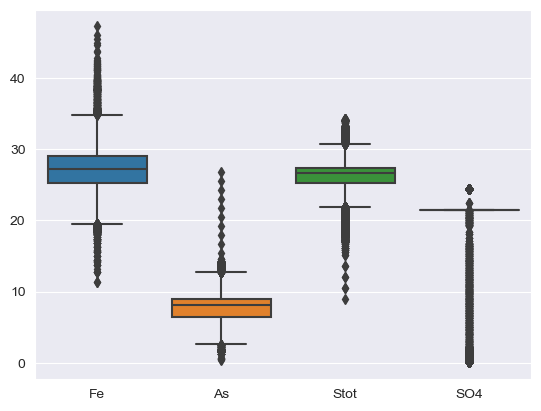

In [48]:
sns.boxplot(data=df_chem[['Fe', 'As', 'Stot', 'SO4']]);

Видно, что данные по сульфатной сере скорее всего ошибочны. Для дальнейшего анализа предлагается их исключить.

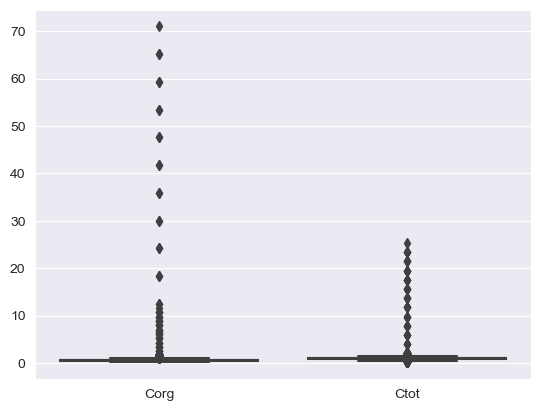

In [49]:
sns.boxplot(data=df_chem[['Corg', 'Ctot']]);

Данные по органическому углероду имеют странные значения. Посмотрим подробнее

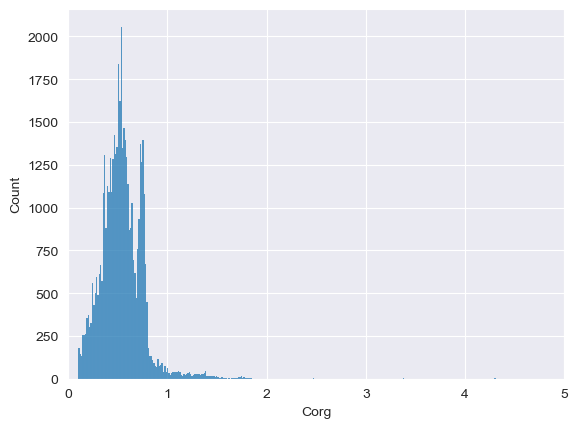

In [50]:
ax = sns.histplot(data=df_chem.reset_index(), x='Corg')
ax.set_xlim([0, 5]);

По приведенным выше графикам видно, что большинство значений концентрации органического углерода находится в диапазоне от 0 до 2. Остальные значения единичны и могут считаться погрешностями определения.

In [51]:
df_chem.shape

(47415, 12)

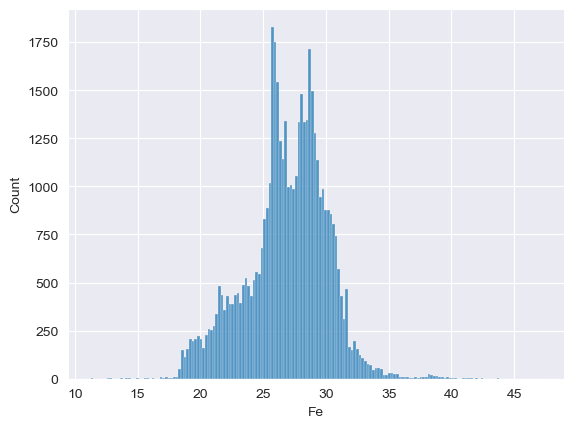

In [52]:
sns.histplot(data=df_chem.reset_index(), x='Fe');

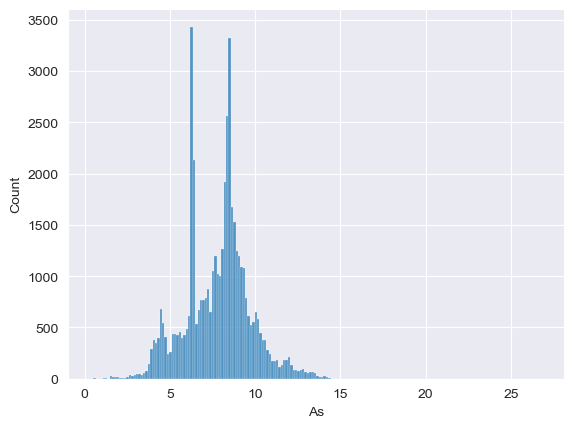

In [53]:
sns.histplot(data=df_chem.reset_index(), x='As');

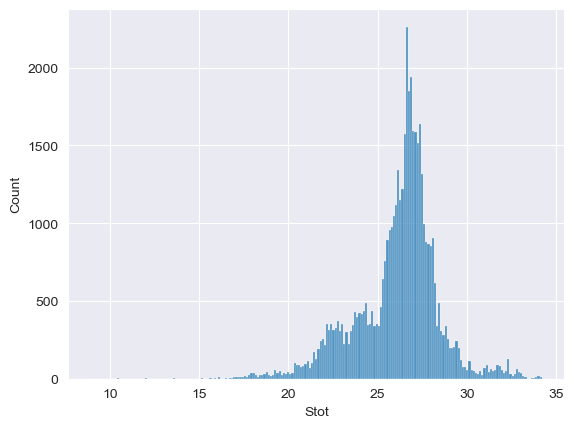

In [54]:
sns.histplot(data=df_chem.reset_index(), x='Stot');

In [55]:
df_chem.loc[df_chem['As'] > 15]

,Fel_1,Fel_2,Fe,Stot,SO4,As,Corg,Ctot,Fe2+,D_S,D_SL_H,ac
,,,,,,,,,,,,
2019-01-26 00:00:00,40.52,0.00,28.54,26.80,24.40,26.80,0.33,1.01,1.63,"3,900.00","1,580.76",104
2019-01-26 02:00:00,39.51,0.00,28.56,26.80,24.40,25.54,0.35,1.01,1.41,"3,900.00","1,575.07",104
2019-01-26 04:00:00,39.55,0.00,28.57,26.80,24.40,24.27,0.35,1.01,1.41,"3,900.00","1,569.38",104
2019-01-26 06:00:00,39.53,0.00,28.59,26.80,24.40,23.01,0.36,1.01,1.18,"3,900.00","1,563.68",104
2019-01-26 08:00:00,39.54,0.00,28.61,26.80,24.40,21.74,0.37,1.00,1.07,"3,900.00","1,575.21",104
2019-01-26 10:00:00,39.51,0.00,28.63,26.80,24.40,20.48,0.37,1.00,1.12,"3,900.00","1,577.29",104
2019-01-26 12:00:00,39.47,0.00,28.64,26.80,24.40,19.21,0.38,1.00,1.74,"3,900.00","1,579.38",104
2019-01-26 14:00:00,39.52,0.00,28.66,26.80,24.40,17.95,0.39,1.00,1.29,"3,900.00","1,581.46",104
2019-01-26 16:00:00,39.16,0.00,28.68,26.80,24.40,16.68,0.39,1.00,1.35,"3,900.00","1,583.54",104


По мышьяку скорее всего имеет место ошибка анализа, лучше эти данные удалить. Для границы можно взять значение в 16 %. Большие значения получены в только в один день и скорее всего являются ошибкой анализа.

По распределению железа наблюдается странная граница на 18 %, меньше 18 % железа имеют всего 68 точек, а вот меньше 19 % уже 453.

In [56]:
df_chem.loc[df_chem['Fe'] < 15]

,Fel_1,Fel_2,Fe,Stot,SO4,As,Corg,Ctot,Fe2+,D_S,D_SL_H,ac
,,,,,,,,,,,,
2020-01-12 04:00:00,0.00,33.39,14.97,21.82,21.50,4.82,0.65,1.73,0.89,"3,820.00","1,606.25",101
2020-01-12 05:00:00,0.00,33.39,14.36,21.85,21.50,4.66,0.65,1.74,0.90,"3,820.00","1,606.50",101
2020-01-12 06:00:00,0.00,33.41,13.75,21.88,21.50,4.49,0.64,1.74,0.91,"3,820.00","1,606.75",101
2019-06-07 05:00:00,0.00,41.39,14.29,25.87,0.12,7.22,0.51,1.02,0.60,"3,900.00","1,601.11",102
2019-06-07 06:00:00,0.00,42.08,12.78,25.88,0.12,6.78,0.51,1.01,0.81,"3,900.00","1,600.97",102
2019-06-07 07:00:00,0.00,42.15,11.27,25.90,0.12,6.34,0.51,0.99,0.84,"3,900.00","1,600.83",102
2019-06-07 08:00:00,0.00,40.55,12.73,25.88,0.13,6.77,0.51,0.98,0.68,"3,900.00","1,600.97",102
2019-06-07 09:00:00,0.00,39.50,14.19,25.85,0.14,7.20,0.51,0.98,0.71,"3,900.00","1,601.11",102
2020-01-12 04:00:00,0.00,48.43,14.97,21.82,21.50,4.82,0.65,1.73,0.81,"3,820.00","1,606.25",102


Почистим данные по химии

In [60]:
CORG_MAX = 2
CTOT_MAX = 3.5
AS_S_MAX = 16

df_chem.drop(df_chem[df_chem['Corg'] > CORG_MAX].index, inplace=True)
df_chem.drop(df_chem[df_chem['Ctot'] > CTOT_MAX].index, inplace=True)
df_chem.drop(df_chem[df_chem['As'] > AS_S_MAX].index, inplace=True)
df_chem.drop('SO4', axis=1, inplace=True)

KeyError: "['SO4'] not found in axis"

Посмотрим на статистики получившегося массива

In [61]:
df_chem.describe().T

,count,mean,std,min,25%,50%,75%,max
Fel_1,"47,290.00",23.46,19.65,0.00,0.00,28.60,42.40,50.55
Fel_2,"47,290.00",22.84,19.70,0.00,0.00,28.16,41.80,50.52
Fe,"47,290.00",26.89,3.24,11.27,25.20,27.13,29.04,47.19
Stot,"47,290.00",26.13,2.31,8.93,25.20,26.58,27.38,34.20
As,"47,290.00",7.82,1.91,0.37,6.37,8.13,8.90,15.42
Corg,"47,290.00",0.54,0.20,0.10,0.41,0.53,0.66,1.85
Ctot,"47,290.00",1.00,0.27,0.18,0.85,1.01,1.11,2.17
Fe2+,"47,290.00",1.38,0.82,0.08,0.95,1.26,1.66,19.50
D_S,"47,290.00","3,843.79",167.19,"3,200.00","3,800.00","3,900.00","3,920.00","4,300.00"
D_SL_H,"47,290.00","1,651.65",69.26,"1,140.35","1,608.86","1,638.67","1,696.92","3,891.67"


Посмотрим на распределение углерода общего и органического.

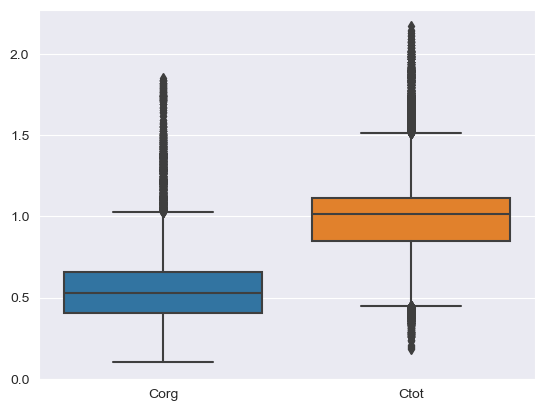

In [62]:
sns.boxplot(data=df_chem[['Corg', 'Ctot']]);

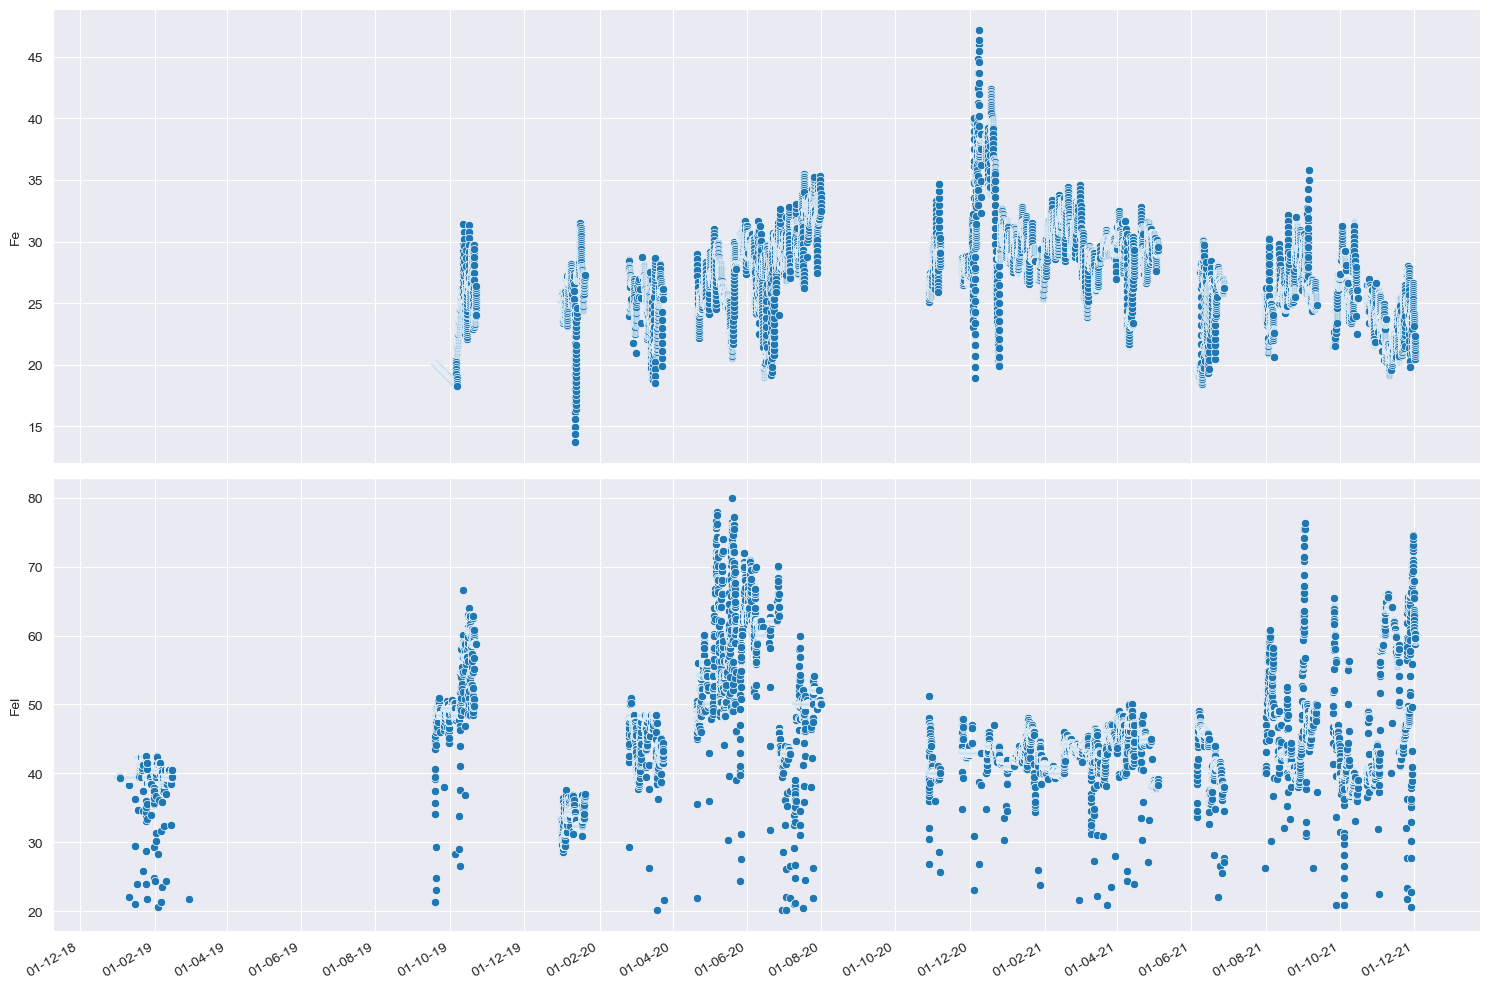

In [89]:
f, ax = plt.subplots(2, 1, figsize=(15,10), sharex=True)

sns.scatterplot(data=df_chem[df_chem['ac'] == 101], y='Fe', x=df_chem[df_chem['ac'] == 101].index, ax=ax[0])

df['Fel'] = df['Fel_1'] + df['Fel_2']
sns.scatterplot(data=df[df['ac'] == 101], y='Fel', x=df[df['ac'] == 101].index, ax=ax[1])

ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
ax[0].xaxis.set_major_locator(mdates.MonthLocator(interval=2))

f.autofmt_xdate()
f.tight_layout()

plt.show()

### Проанализируем данные по плотности пульпы

In [63]:
df_chem.loc['2019-09-05':'2019-09-06']

,Fel_1,Fel_2,Fe,Stot,As,Corg,Ctot,Fe2+,D_S,D_SL_H,ac
,,,,,,,,,,,
2019-09-05 00:00:00,0.00,50.35,21.47,24.18,8.20,0.37,0.87,0.85,"3,500.00","1,554.44",104
2019-09-05 01:00:00,0.00,50.40,21.47,24.18,8.20,0.37,0.87,1.02,"3,500.00","1,553.33",104
2019-09-05 02:00:00,0.00,50.35,21.46,24.18,8.20,0.37,0.87,0.87,"3,500.00","1,552.22",104
2019-09-05 03:00:00,0.00,50.37,21.46,24.19,8.20,0.37,0.87,0.97,"3,500.00","1,551.11",104
2019-09-05 04:00:00,0.00,50.38,21.46,24.19,8.20,0.37,0.87,1.01,"3,500.00","1,550.00",104
2019-09-05 05:00:00,0.00,50.38,21.45,24.19,8.20,0.37,0.87,0.87,"3,500.00","1,548.89",104
2019-09-05 06:00:00,0.00,50.30,21.45,24.20,8.20,0.37,0.87,1.03,"3,500.00","1,547.78",104
2019-09-05 07:00:00,0.00,50.34,21.44,24.20,8.20,0.37,0.87,1.00,"3,500.00","1,546.67",104
2019-09-05 08:00:00,0.00,50.38,21.44,24.20,8.20,0.37,0.87,0.97,"3,500.00","1,742.08",104


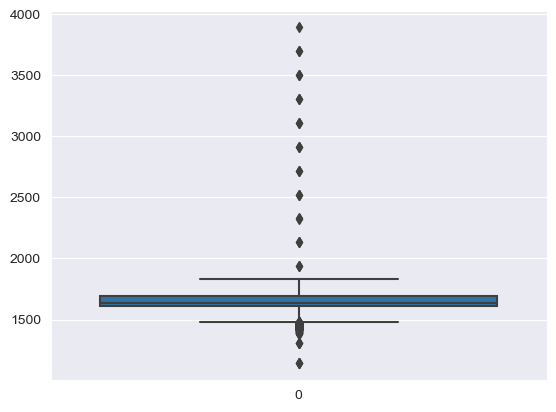

In [64]:
sns.boxplot(data=df_chem['D_SL_H']);

In [65]:
d_sl_h_min, d_sl_h_max = stat_min_max(df_chem['D_SL_H'], scale=2)

In [66]:
print(d_sl_h_min, d_sl_h_max)

1432.7499999999998 1873.027777777778


In [67]:
df_chem.loc[df_chem['D_SL_H'] > d_sl_h_max]

,Fel_1,Fel_2,Fe,Stot,As,Corg,Ctot,Fe2+,D_S,D_SL_H,ac
,,,,,,,,,,,
2019-09-05 09:00:00,0.00,50.37,21.44,24.20,8.20,0.37,0.87,0.95,"3,500.00","1,937.50",104
2019-09-05 10:00:00,0.00,50.38,21.43,24.21,8.20,0.37,0.87,0.90,"3,500.00","2,132.92",104
2019-09-05 11:00:00,0.00,50.39,21.43,24.21,8.19,0.37,0.87,0.84,"3,500.00","2,328.33",104
2019-09-05 12:00:00,0.00,50.39,21.42,24.21,8.19,0.37,0.87,0.77,"3,500.00","2,523.75",104
2019-09-05 13:00:00,0.00,50.48,21.42,24.22,8.19,0.37,0.87,0.79,"3,500.00","2,719.17",104
2019-09-05 14:00:00,0.00,50.43,21.42,24.22,8.19,0.37,0.87,0.78,"3,500.00","2,914.58",104
2019-09-05 15:00:00,0.00,50.37,21.41,24.22,8.19,0.37,0.87,0.74,"3,500.00","3,110.00",104
2019-09-05 16:00:00,0.00,50.34,21.41,24.23,8.19,0.37,0.87,0.69,"3,500.00","3,305.42",104
2019-09-05 17:00:00,0.00,50.40,21.40,24.23,8.19,0.37,0.87,0.78,"3,500.00","3,500.83",104


Удалим данные по плотности пульпы которые выходят за рамки d_sl_h_max. Граничное значение считается, как 75% квартиль плюс 2 межквартильных размаха (разница 75 и 25 квартиля).

In [68]:
D_SL_H_MAX = d_sl_h_max

In [69]:
df_chem.drop(df_chem[df_chem['D_SL_H'] > D_SL_H_MAX].index, inplace=True)

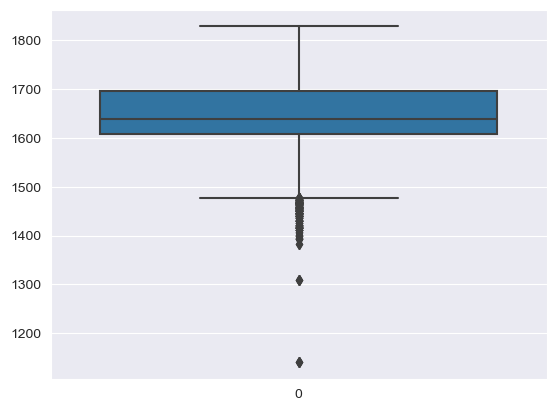

In [70]:
sns.boxplot(data=df_chem['D_SL_H']);

Посчитаем сколько пирита и арсенопирита поступает в переработку

In [71]:
FELUWA_MAX_Q = 17.45
FELUWA_MAX_N = 51
COEF_AS_SEQ = 0.371
D_WATER = 1000

M_As = 74.92
M_Fe = 55.85
M_S = 32.06

M_FeS2 = M_Fe + 2 * M_S
M_FeAsS = M_Fe + M_As + M_S

In [72]:
fel_sum = df_chem['Fel_1'] + df_chem['Fel_2']
df_chem = df_chem.assign(Fel_sum=fel_sum.values)

df_chem = df_chem.assign(C_Solid=(df_chem['D_S'] * D_WATER - df_chem['D_SL_H'] * df_chem['D_S']) / (
        df_chem['D_SL_H'] * D_WATER - df_chem['D_SL_H'] * df_chem['D_S']) * 100)
df_chem = df_chem.assign(Q_SL=df_chem['Fel_sum'] / FELUWA_MAX_N * FELUWA_MAX_Q)
df_chem = df_chem.assign(G_Solid=df_chem['Q_SL'] * df_chem['D_SL_H'] / 1000 * (df_chem['C_Solid'] / 100))
df_chem = df_chem.assign(G_Seq=(COEF_AS_SEQ * df_chem['As'] / 100 + df_chem['Stot'] / 100) * df_chem['G_Solid'])

df_chem = df_chem.assign(G_FeS2=((df_chem['Stot'] - df_chem['As'] / M_As * M_S) / 2 / M_S * M_FeS2) / 100 * df_chem['G_Solid'])
df_chem = df_chem.assign(G_FeAsS=(df_chem['As'] / M_As * M_FeAsS) / 100 * df_chem['G_Solid'])

df_chem = df_chem.assign(G_O2_st=df_chem['G_FeS2'] / 2 / M_FeS2 * 7.5 * 22.4 + df_chem['G_FeAsS'] / M_FeAsS * 3.5 * 22.4)
# df_chem = df_chem.assign(O2_part=df['G_O2_st'] / df['O2_tot'])

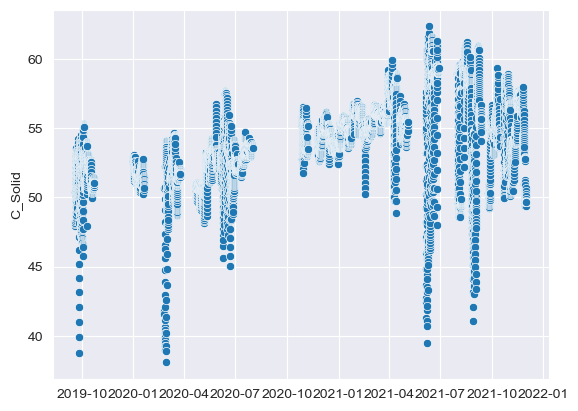

In [73]:
sns.scatterplot(data=df_chem[df_chem['ac'] == 101], y='C_Solid', x=df_chem[df_chem['ac'] == 101].index);

In [74]:
df_chem.describe().T

,count,mean,std,min,25%,50%,75%,max
Fel_1,"47,269.00",23.47,19.65,0.00,0.00,28.63,42.40,50.55
Fel_2,"47,269.00",22.83,19.69,0.00,0.00,28.16,41.77,50.52
Fe,"47,269.00",26.89,3.24,11.27,25.20,27.13,29.04,47.19
Stot,"47,269.00",26.13,2.31,8.93,25.21,26.58,27.39,34.20
As,"47,269.00",7.82,1.91,0.37,6.37,8.13,8.90,15.42
Corg,"47,269.00",0.54,0.20,0.10,0.41,0.53,0.66,1.85
Ctot,"47,269.00",1.00,0.27,0.18,0.85,1.01,1.11,2.17
Fe2+,"47,269.00",1.38,0.82,0.08,0.95,1.26,1.66,19.50
D_S,"47,269.00","3,843.95",167.07,"3,200.00","3,800.00","3,900.00","3,920.00","4,300.00"
D_SL_H,"47,269.00","1,651.11",63.13,"1,140.35","1,608.83","1,638.58","1,696.83","1,828.00"


## Анализ технологических данных

Перенесем полученные ранее изменения в текущий датафрейм

In [139]:
int_cols = [
    'Fe',
    'Stot',
    'SO4',
    'As',
    'Corg',
    'Ctot',
    'D_S',
    'D_SL_H'
]

df[int_cols] = df.loc[:, int_cols].interpolate(method='time')

In [140]:
FE_MAX = 20
FE_MIN = 0

df.drop(df[df['Fe2+'] == FE_MIN].index, inplace=True)
df.drop(df[df['Fe2+'] > FE_MAX].index, inplace=True)

CORG_MAX = 2
CTOT_MAX = 5
AS_S_MAX = 16

df.drop(df[df['Ctot'] > CTOT_MAX].index, inplace=True)
df.drop(df[df['Corg'] > CORG_MAX].index, inplace=True)
df.drop(df[df['As'] > AS_S_MAX].index, inplace=True)
df.drop('SO4', axis=1, inplace=True)

D_SL_H_MAX = 1868
df.drop(df[df['D_SL_H'] > D_SL_H_MAX].index, inplace=True)

### Добавим новые признаки

In [141]:
FELUWA_MAX_Q = 17.45
FELUWA_MAX_N = 51
COEF_AS_SEQ = 0.371
D_WATER = 1000

M_As = 74.92
M_Fe = 55.85
M_S = 32.06

M_FeS2 = M_Fe + 2 * M_S
M_FeAsS = M_Fe + M_As + M_S

In [142]:
df = df.assign(C_Solid=(df['D_S'] * D_WATER - df['D_SL_H'] * df['D_S']) / (
        df['D_SL_H'] * D_WATER - df['D_SL_H'] * df['D_S']) * 100)
df = df.assign(Q_SL=df['Fel_sum'] / FELUWA_MAX_N * FELUWA_MAX_Q)
df = df.assign(G_Solid=df['Q_SL'] * df['D_SL_H'] / 1000 * (df['C_Solid'] / 100))
df = df.assign(G_Seq=(COEF_AS_SEQ * df['As'] / 100 + df['Stot'] / 100) * df['G_Solid'])

df = df.assign(G_FeS2=((df['Stot'] - df['As'] / M_As * M_S) / 2 / M_S * M_FeS2) / 100 * df['G_Solid'])
df = df.assign(G_FeAsS=(df['As'] / M_As * M_FeAsS) / 100 * df['G_Solid'])

df = df.assign(G_O2_st=(df['G_FeS2'] / 2 / M_FeS2 * 7.5 * 22.4 + df['G_FeAsS'] / M_FeAsS * 3.5 * 22.4) * 1000)
df = df.assign(O2_part=df['G_O2_st'] / df['O2_tot'])

In [159]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Fel_1,"47,660.00",23.60,19.63,0.00,0.00,29.00,42.40,50.55
Fel_2,"47,660.00",22.66,19.72,0.00,0.00,28.13,41.54,50.52
D_SL,"47,660.00","1,562.60",242.87,975.12,"1,596.20","1,639.57","1,690.04","2,032.16"
QQ_C1,"47,660.00",15.12,8.20,-0.01,8.76,15.79,20.95,39.86
QQ_C2,"47,660.00",30.40,7.12,0.01,27.50,31.63,34.93,46.08
...,...,...,...,...,...,...,...,...
G_Seq,"47,652.00",4.02,0.70,0.83,3.55,3.94,4.42,8.69
G_FeS2,"47,652.00",5.92,1.19,1.10,5.03,5.87,6.65,12.76
G_FeAsS,"47,652.00",2.34,0.61,0.12,1.90,2.33,2.68,5.78
G_O2_st,"47,652.00","5,266.53",921.43,"1,088.23","4,649.88","5,157.03","5,788.54","11,381.68"


### Анализ подачи материала

Посмотрим, если взаимосвязь целевой переменной и данных по подаче материала.

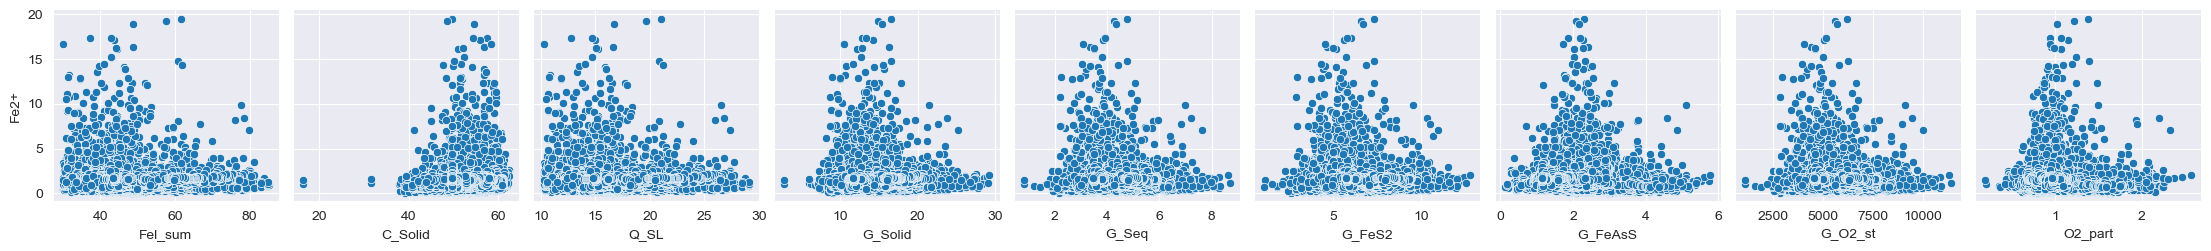

In [165]:
cols = ['Fel_sum',
        'C_Solid',
        'Q_SL',
        'G_Solid',
        'G_Seq',
        'G_FeS2',
        'G_FeAsS',
        'G_O2_st',
        'O2_part']

_ = sns.pairplot(data=df, y_vars='Fe2+', x_vars=cols)

### Анализ воды и кислорода

In [160]:
df.loc[df['O2_part'] > 2, ['Fel_sum', 'ac', 'O2_tot', 'G_O2_st', 'O2_part']]

,Fel_sum,ac,O2_tot,G_O2_st,O2_part
,,,,,
2021-06-05 19:00:00,75.28,102,"4,692.09","9,485.01",2.02
2021-06-06 08:00:00,73.93,102,"4,449.39","9,320.44",2.09
2021-06-06 09:00:00,74.00,102,"4,450.50","9,359.62",2.10
2021-06-06 11:00:00,73.95,102,"4,450.08","9,419.51",2.12
2021-06-06 12:00:00,73.93,102,"4,449.03","9,453.79",2.12
...,...,...,...,...,...
2021-06-07 08:00:00,78.53,104,"4,698.34","9,468.81",2.02
2021-06-08 15:00:00,73.41,104,"4,599.82","9,433.15",2.05
2021-06-08 16:00:00,75.20,104,"4,598.92","9,978.81",2.17


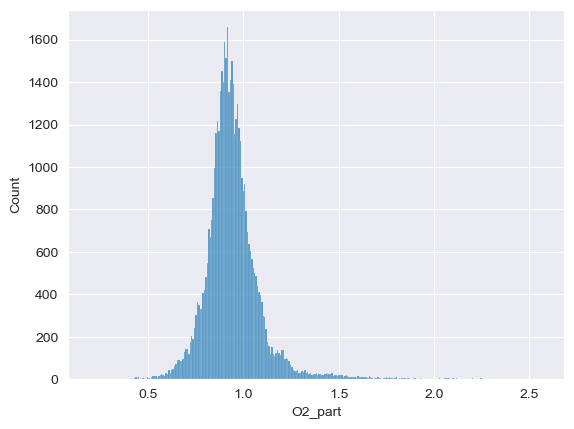

In [161]:
sns.histplot(data=df.reset_index(), x='O2_part');

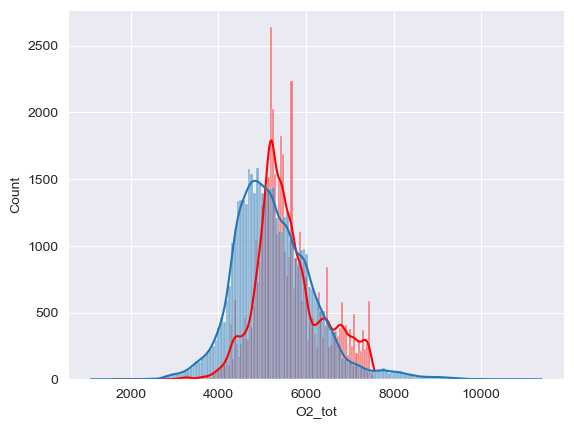

In [164]:
sns.histplot(data=df.reset_index(), x='O2_tot', color='r', kde=True)
sns.histplot(data=df.reset_index(), x='G_O2_st', kde=True);

### Степени окисления по кислороду и воде

Добавим степень окисления по секциям автоклава по воде и кислороду

In [167]:
df = df.assign(BettaS_O2_1=df['O2_C1'] / df['O2_tot'])
df = df.assign(BettaS_O2_2=df['O2_C2'] / df['O2_tot'])
df = df.assign(BettaS_O2_3=df['O2_C3'] / df['O2_tot'])
df = df.assign(BettaS_O2_4=df['O2_C4'] / df['O2_tot'])
df = df.assign(BettaS_O2_5=df['O2_C5'] / df['O2_tot'])

In [177]:
df = df.assign(QQ_tot_sl=df['QQ_tot'] + + df['Q_SL'] - df['G_Solid'] / df['D_S'])

df = df.assign(BettaS_QW_1=(df['QQ_C1'] + df['Q_SL'] - df['G_Solid'] / df['D_S']) / df['QQ_tot_sl'])
df = df.assign(BettaS_QW_2=df['QQ_C2'] / df['QQ_tot_sl'])
df = df.assign(BettaS_QW_3=df['QQ_C3'] / df['QQ_tot_sl'])
df = df.assign(BettaS_QW_4=df['QQ_C4'] / df['QQ_tot_sl'])
df = df.assign(BettaS_QW_5=df['QQ_C5'] / df['QQ_tot_sl'])

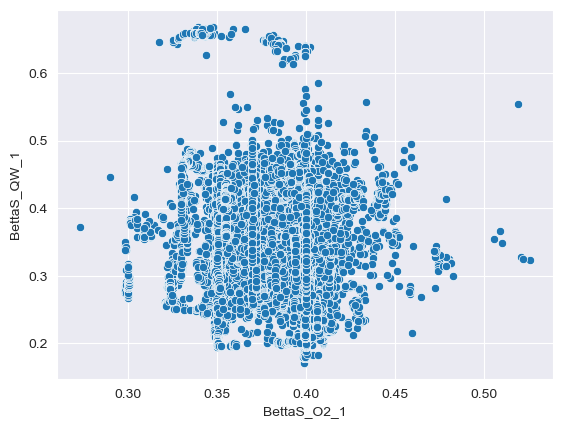

In [178]:
sns.scatterplot(data=df, x='BettaS_O2_1', y='BettaS_QW_1');

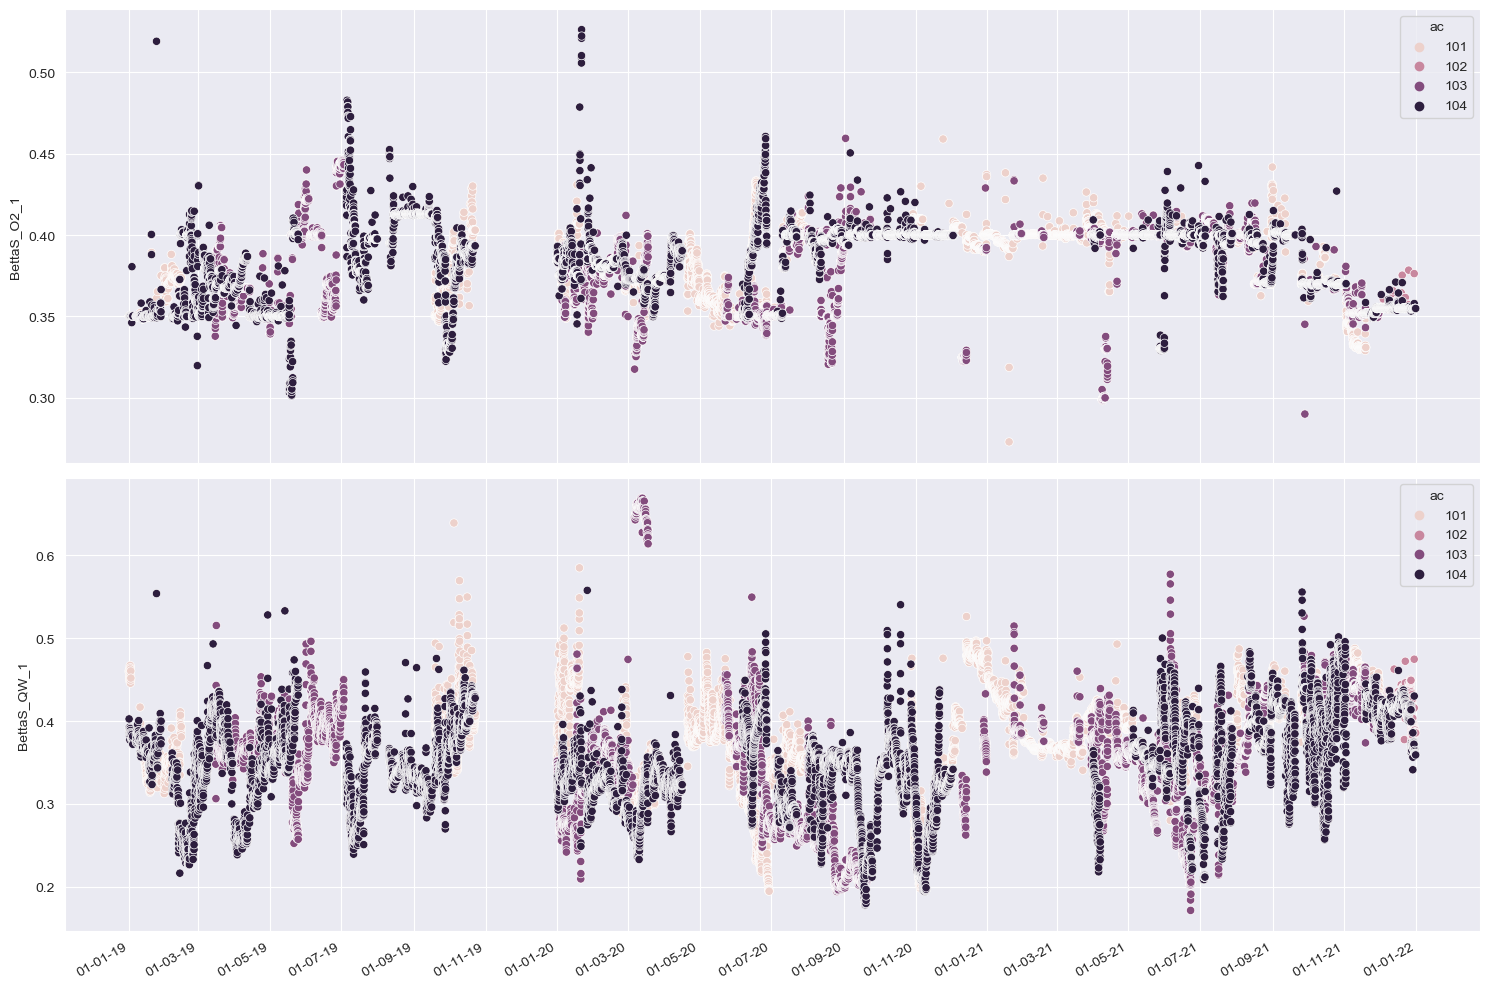

In [179]:
f, ax = plt.subplots(2, 1, figsize=(15,10), sharex=True)

sns.scatterplot(data=df, y='BettaS_O2_1', x=df.index, hue='ac' ,ax=ax[0])
sns.scatterplot(data=df, y='BettaS_QW_1', x=df.index, hue='ac' ,ax=ax[1])

ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
ax[0].xaxis.set_major_locator(mdates.MonthLocator(interval=2))

f.autofmt_xdate()
f.tight_layout()

plt.show()

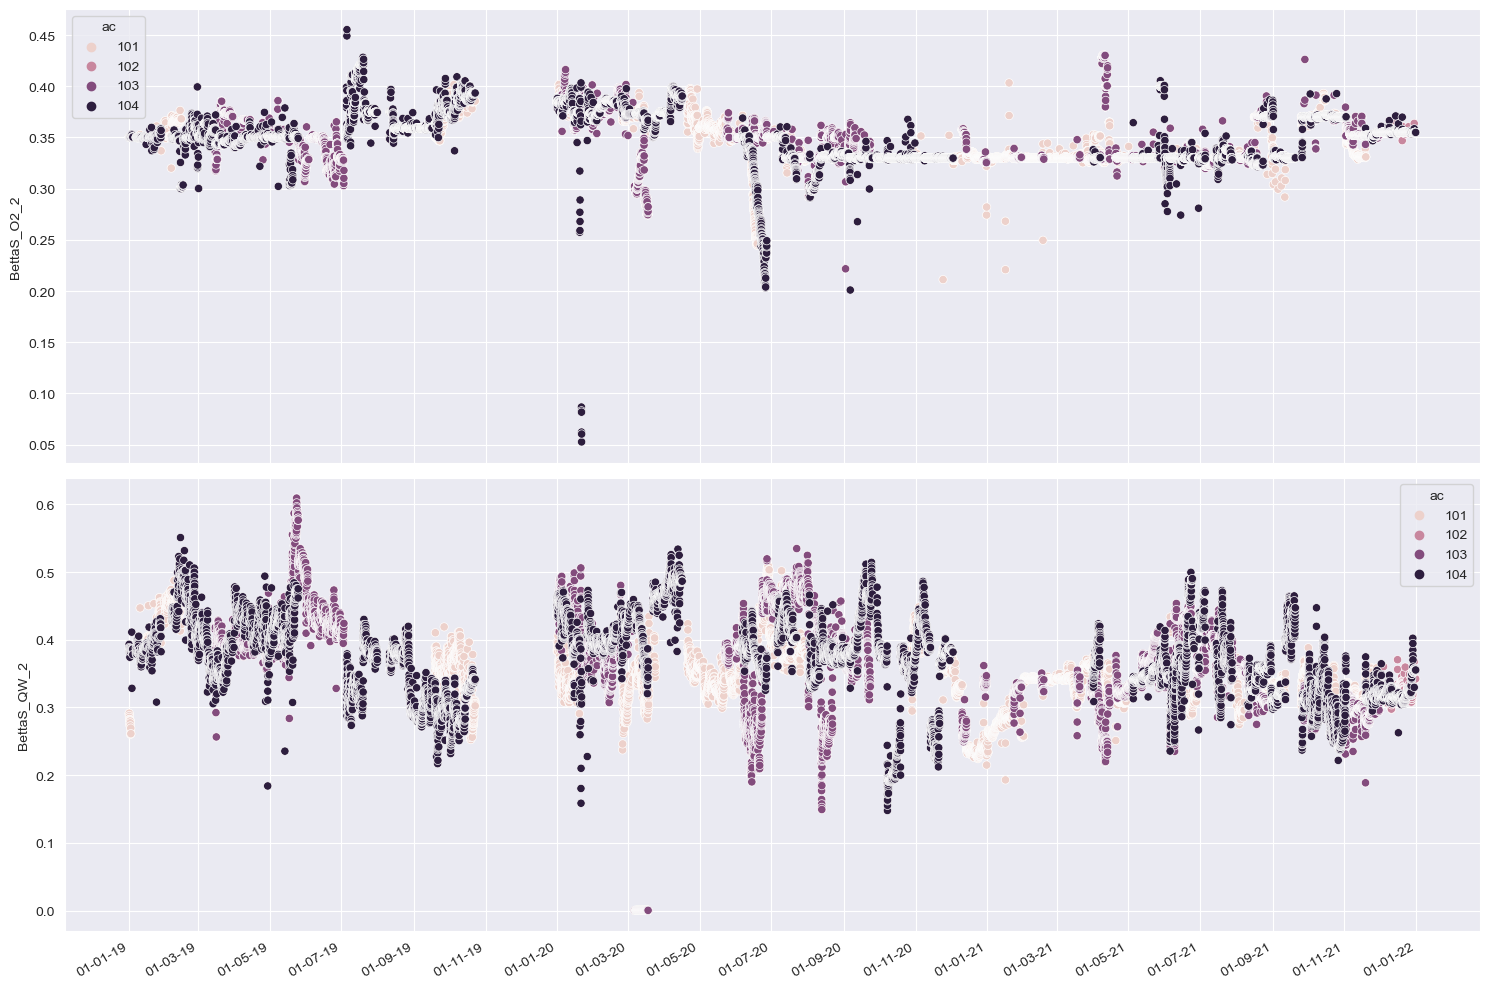

In [180]:
f, ax = plt.subplots(2, 1, figsize=(15,10), sharex=True)

sns.scatterplot(data=df, y='BettaS_O2_2', x=df.index, hue='ac' ,ax=ax[0])
sns.scatterplot(data=df, y='BettaS_QW_2', x=df.index, hue='ac' ,ax=ax[1])

ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
ax[0].xaxis.set_major_locator(mdates.MonthLocator(interval=2))

f.autofmt_xdate()
f.tight_layout()

plt.show()

Проверим что суммарная степень окисления получается равная 1

In [183]:
assert_almost_equal((df['BettaS_O2_1'] + df['BettaS_O2_2'] + df['BettaS_O2_3'] + df['BettaS_O2_4'] + df['BettaS_O2_5']).mean(), 1, decimal=4)
assert_almost_equal((df['BettaS_QW_1'] + df['BettaS_QW_2'] + df['BettaS_QW_3'] + df['BettaS_QW_4'] + df['BettaS_QW_5']).mean(), 1, decimal=4)